In [1]:
import os

new_directory = '/kaggle/working/new'

if not os.path.exists(new_directory):
    os.makedirs(new_directory)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cross_decomposition
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set()

# Make charts a bit bolder
#sns.set_context("talk")

%matplotlib inline

# Default figure size
sns.set(rc={"figure.figsize": (12, 6)})

# This actually makes autocomplete WAY faster ...
%config Completer.use_jedi = False

# Show only 2 decimals for floating point numbers
pd.options.display.float_format = "{:.2f}".format

sns.set_style('whitegrid')

In [3]:
data = pd.read_csv('../input/imp6-data/imp6_comparison_data.csv')

In [4]:
data.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,stacks,STX,Stacks,11/30/2023,50,0.63,0.80,0.59,0.69,1754323996.86,984407215.75,0.50,0.21
1,stacks,STX,Stacks,10/31/2023,50,0.48,0.75,0.47,0.63,1556859746.15,886748303.76,0.56,0.27
2,stacks,STX,Stacks,09/30/2023,50,0.49,0.50,0.42,0.48,666697766.99,678144741.81,0.73,0.08
3,stacks,STX,Stacks,08/31/2023,50,0.59,0.63,0.42,0.49,1263115200.47,687309949.75,0.33,0.21
4,stacks,STX,Stacks,07/31/2023,50,0.69,0.75,0.58,0.59,1307521326.00,820973409.05,0.03,0.17


In [5]:
data.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread
count,251.00,251.00,251.00,251.00,251.00,251.00,251.00,251.00,251.00
mean,69.24,40.73,65.44,29.06,40.91,5690867891.27,1393344697.93,0.42,36.38
std,22.11,168.87,280.52,113.82,168.81,11975302625.16,1943265658.67,0.26,206.02
min,50.00,0.03,0.03,0.00,0.03,181369.34,4613674.62,0.00,0.01
25%,61.00,0.40,0.58,0.33,0.43,473225933.45,205149497.99,0.19,0.17
50%,62.00,0.98,1.30,0.74,1.00,1622412454.56,782767756.02,0.43,0.59
75%,67.00,6.64,8.53,5.02,6.64,6203383893.50,1400396685.60,0.63,3.65
max,124.00,1846.88,2868.95,991.07,1844.23,103861212952.30,12367095438.10,1.00,2829.36


In [6]:
data.shape, data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 13 columns):
slug           251 non-null object
symbol         251 non-null object
name           251 non-null object
date           251 non-null object
ranknow        251 non-null int64
open           251 non-null float64
high           251 non-null float64
low            251 non-null float64
close          251 non-null float64
volume         251 non-null float64
market         251 non-null float64
close_ratio    251 non-null float64
spread         251 non-null float64
dtypes: float64(8), int64(1), object(4)
memory usage: 25.6+ KB


((251, 13), None)

Here are the descriptions for some of the columns that I wasn't really sure about:

* volume - Transactions volume
* market - Market Cap
* ranknow - Currency rank
* spread - Spread between high and low

Also, one thing I noticed -- market caps are quite huge. For ease of observing, let's introduce a new column - *market_billion*, which will represent currencies Market Cap in billion

## Data Wrangle & Cleanup

In [7]:
# Convert date to real date
data['date'] = pd.to_datetime(data['date'])
data['market_billion'] = data['market'] / 1000000000
data['volume_million'] = data['volume'] / 1000000000
data['volume_billion'] = data['volume']

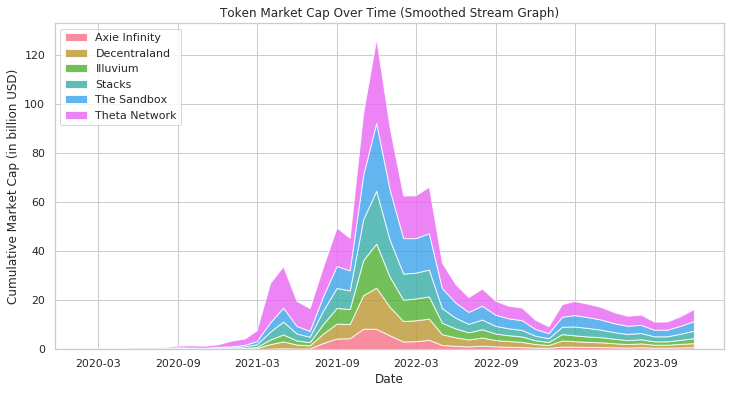

In [8]:
# Extract relevant columns for stream graph
stream_data = data[['date', 'name', 'market_billion']]

# Pivot the dataframe to have 'date' as index, 'name' as columns, and 'market_billion' as values
stream_data_pivot = stream_data.pivot_table(index='date', columns='name', values='market_billion', fill_value=0)

# Interpolate missing values to make the stream graph smoother
stream_data_pivot = stream_data_pivot.interpolate(method='linear', axis=0)

# Calculate cumulative sum for each column (token)
cumulative_sum_data = stream_data_pivot.cumsum(axis=1)

# Create a list of colors for each token
colors = sns.color_palette("husl", n_colors=len(cumulative_sum_data.columns))

# Plot the stream graph
plt.figure(figsize=(12, 6))
plt.stackplot(cumulative_sum_data.index, cumulative_sum_data.values.T, labels=cumulative_sum_data.columns, colors=colors, alpha=0.8)
plt.title('Token Market Cap Over Time (Smoothed Stream Graph)')
plt.xlabel('Date')
plt.ylabel('Cumulative Market Cap (in billion USD)')
plt.legend(loc='upper left')
plt.show()

In [9]:
# Let's prepare one dataframe where we will observe closing prices for each currency
wide_format = data.groupby(['date', 'name'])['close'].last().unstack()
wide_format.head(3)

name,Axie Infinity,Decentraland,Illuvium,Stacks,The Sandbox,Theta Network
date,,,,,,
2020-01-31,nan,0.04,nan,0.10,nan,0.10
2020-02-29,nan,0.04,nan,0.12,nan,0.12
2020-03-31,nan,0.03,nan,0.09,nan,0.07


In [10]:
wide_format.shape

(47, 6)

In [11]:
wide_format.describe()

name,Axie Infinity,Decentraland,Illuvium,Stacks,The Sandbox,Theta Network
count,37.00,47.00,33.00,47.00,40.00,47.00
mean,26.19,0.83,274.71,0.73,1.11,2.46
std,36.06,1.01,394.52,0.62,1.51,2.94
min,0.46,0.03,38.37,0.09,0.04,0.07
25%,5.70,0.12,51.64,0.25,0.33,0.68
50%,9.22,0.55,70.87,0.57,0.62,1.07
75%,29.10,0.91,453.64,0.97,1.00,3.24
max,138.29,4.64,1844.23,2.77,6.77,12.37


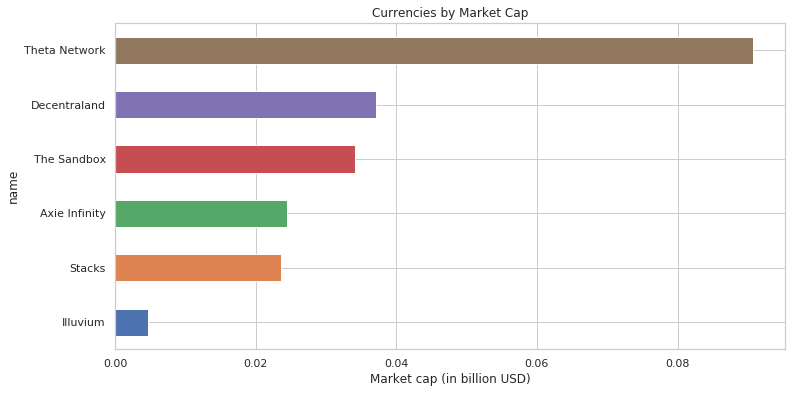

In [12]:
ax = data.groupby(['name'])['market_billion'].last().sort_values(ascending=False).head(10).sort_values().plot(kind='barh');
ax.set_xlabel("Market cap (in billion USD)");
plt.title("Currencies by Market Cap");
plt.savefig('currencies_by_market_cap.png');

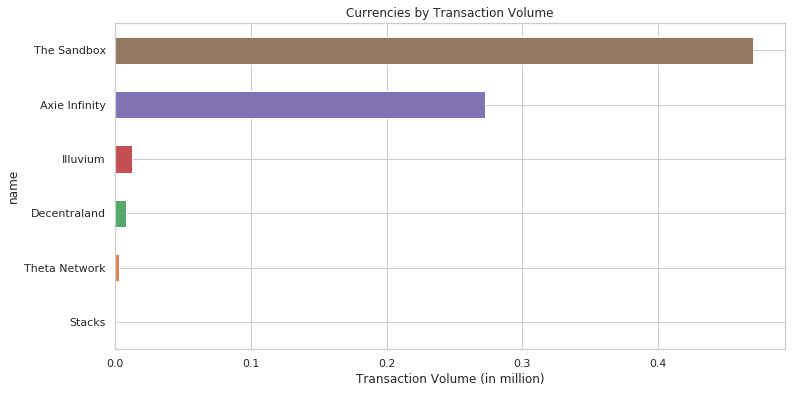

In [13]:
ax = data.groupby(['name'])['volume_million'].last().sort_values(ascending=False).head(10).sort_values().plot(kind='barh');
ax.set_xlabel("Transaction Volume (in million)");
plt.title("Currencies by Transaction Volume");
plt.savefig('currencies_by_transactin_volume.png');

In [14]:
# For sake of convenience, let's define the top 5 currencies

top_5_currency_names = data.groupby(['name'])['market'].last().sort_values(ascending=False).head(6).index
data_top_5_currencies = data[data['name'].isin(top_5_currency_names)]
data_top_5_currencies.head(5)
print(top_5_currency_names)

Index(['Theta Network', 'Decentraland', 'The Sandbox', 'Axie Infinity',
       'Stacks', 'Illuvium'],
      dtype='object', name='name')


In [15]:
data_top_5_currencies.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread,market_billion,volume_million,volume_billion
count,251.00,251.00,251.00,251.00,251.00,251.00,251.00,251.00,251.00,251.00,251.00,251.00
mean,69.24,40.73,65.44,29.06,40.91,5690867891.27,1393344697.93,0.42,36.38,1.39,5.69,5690867891.27
std,22.11,168.87,280.52,113.82,168.81,11975302625.16,1943265658.67,0.26,206.02,1.94,11.98,11975302625.16
min,50.00,0.03,0.03,0.00,0.03,181369.34,4613674.62,0.00,0.01,0.00,0.00,181369.34
25%,61.00,0.40,0.58,0.33,0.43,473225933.45,205149497.99,0.19,0.17,0.21,0.47,473225933.45
50%,62.00,0.98,1.30,0.74,1.00,1622412454.56,782767756.02,0.43,0.59,0.78,1.62,1622412454.56
75%,67.00,6.64,8.53,5.02,6.64,6203383893.50,1400396685.60,0.63,3.65,1.40,6.20,6203383893.50
max,124.00,1846.88,2868.95,991.07,1844.23,103861212952.30,12367095438.10,1.00,2829.36,12.37,103.86,103861212952.30


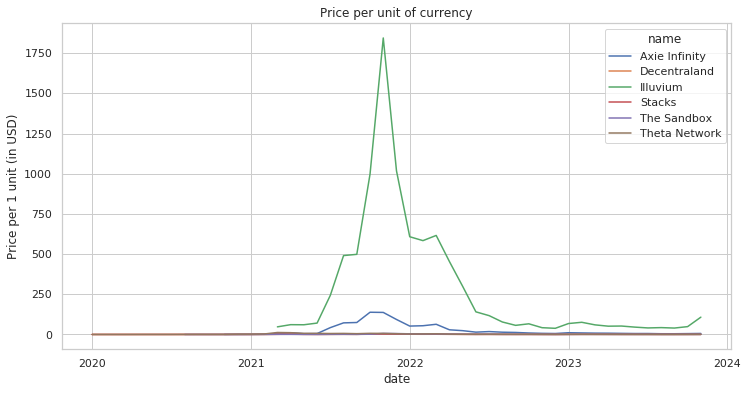

In [16]:
ax = data_top_5_currencies.groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit of currency");
plt.savefig('price_per_unit_curr.png');

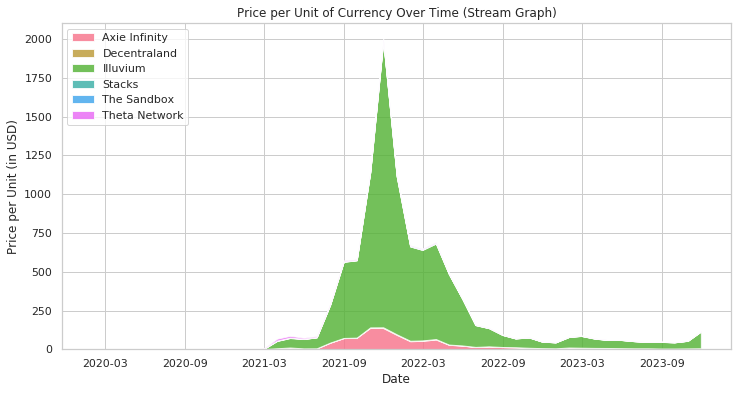

In [17]:
# Extract relevant columns for stream graph
stream_data_price = data_top_5_currencies[['date', 'name', 'close']]

# Pivot the dataframe to have 'date' as index, 'name' as columns, and 'close' as values
stream_data_price_pivot = stream_data_price.pivot_table(index='date', columns='name', values='close', fill_value=0)

# Create a list of colors for each currency
colors_price = sns.color_palette("husl", n_colors=len(stream_data_price_pivot.columns))

# Plot the stream graph
plt.figure(figsize=(12, 6))
plt.stackplot(stream_data_price_pivot.index, stream_data_price_pivot.values.T, labels=stream_data_price_pivot.columns, colors=colors_price, alpha=0.8)
plt.title('Price per Unit of Currency Over Time (Stream Graph)')
plt.xlabel('Date')
plt.ylabel('Price per Unit (in USD)')
plt.legend(loc='upper left')
plt.savefig('new/price_per_unit_curr_stream.png')

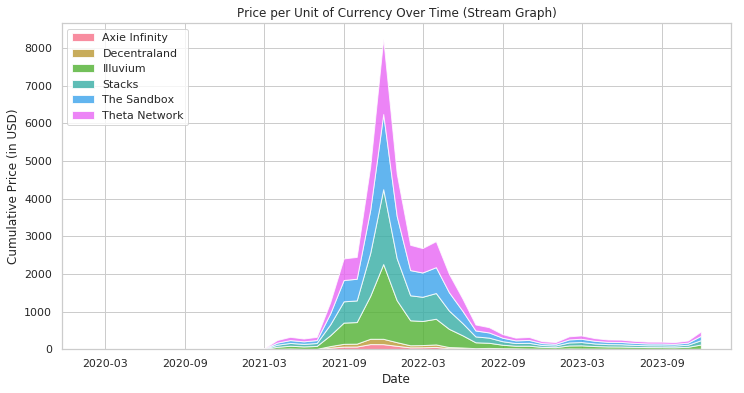

In [18]:
# Extract relevant columns for stream graph
stream_data = data_top_5_currencies[['date', 'name', 'close']]

# Pivot the dataframe to have 'date' as index, 'name' as columns, and 'close' as values
stream_data_pivot = stream_data.pivot_table(index='date', columns='name', values='close', fill_value=0)

# Calculate cumulative sum for each column (currency)
cumulative_sum_data = stream_data_pivot.cumsum(axis=1)

# Create a list of colors for each currency
colors = sns.color_palette("husl", n_colors=len(cumulative_sum_data.columns))

# Plot the stream graph
plt.figure(figsize=(12, 6))
plt.stackplot(cumulative_sum_data.index, cumulative_sum_data.values.T, labels=cumulative_sum_data.columns, colors=colors, alpha=0.8)
plt.title('Price per Unit of Currency Over Time (Stream Graph)')
plt.xlabel('Date')
plt.ylabel('Cumulative Price (in USD)')
plt.legend(loc='upper left')
plt.show()

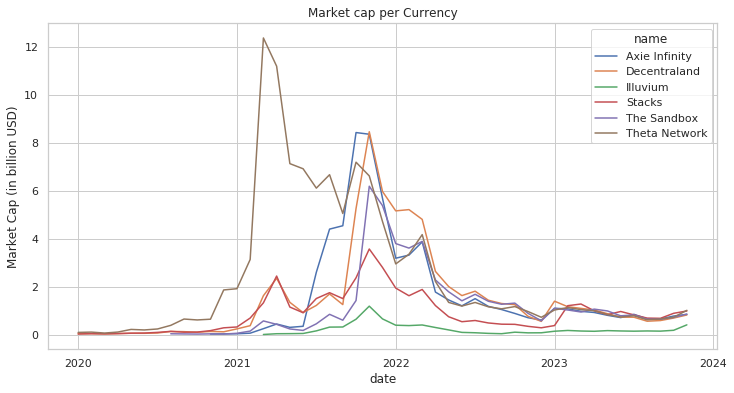

In [19]:
ax = data_top_5_currencies.groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per Currency");
plt.savefig('market_cap_per_curr.png');

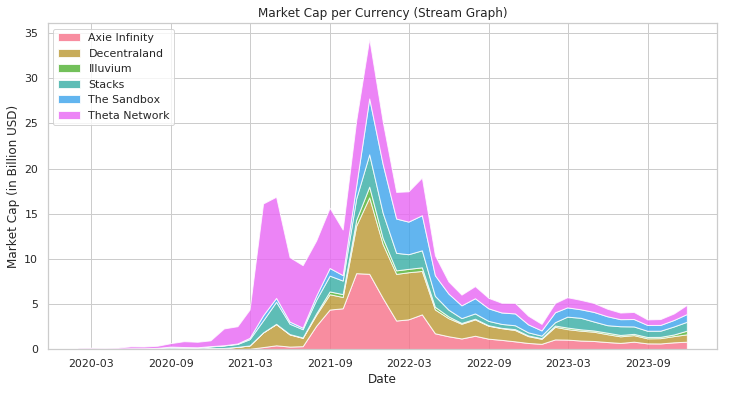

In [20]:
# Extract relevant columns for stream graph
stream_data_market_cap = data_top_5_currencies[['date', 'name', 'market_billion']]

# Pivot the dataframe to have 'date' as index, 'name' as columns, and 'market_billion' as values
stream_data_market_cap_pivot = stream_data_market_cap.pivot_table(index='date', columns='name', values='market_billion', fill_value=0)

# Create a list of colors for each currency
colors_market_cap = sns.color_palette("husl", n_colors=len(stream_data_market_cap_pivot.columns))

# Plot the stream graph
plt.figure(figsize=(12, 6))
plt.stackplot(stream_data_market_cap_pivot.index, stream_data_market_cap_pivot.values.T, labels=stream_data_market_cap_pivot.columns, colors=colors_market_cap, alpha=0.8)
plt.title('Market Cap per Currency (Stream Graph)')
plt.xlabel('Date')
plt.ylabel('Market Cap (in Billion USD)')
plt.legend(loc='upper left')
plt.savefig('new/market_cap_per_curr_stream.png')

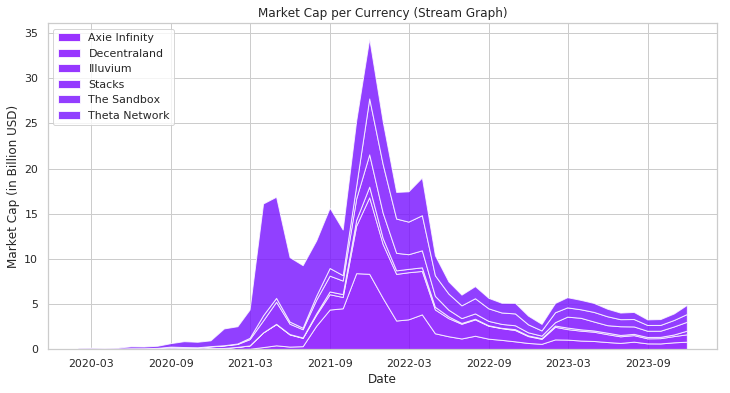

In [21]:
stream_data_market_cap_pivot = data_top_5_currencies.pivot_table(index='date', columns='name', values='market_billion', fill_value=0)

# Create a stream plot
plt.figure(figsize=(12, 6))

# Extract relevant data
dates = stream_data_market_cap_pivot.index
colors = plt.cm.rainbow(range(len(stream_data_market_cap_pivot.columns)))
y = stream_data_market_cap_pivot.T.values

# Plot the stream graph
plt.stackplot(dates, y, labels=stream_data_market_cap_pivot.columns, colors=colors, alpha=0.8)

# Customize the plot
plt.title("Market Cap per Currency (Stream Graph)")
plt.xlabel("Date")
plt.ylabel("Market Cap (in Billion USD)")
plt.legend(loc='upper left')

# Save the figure
plt.savefig('market_cap_per_curr_stream.png')
plt.show()

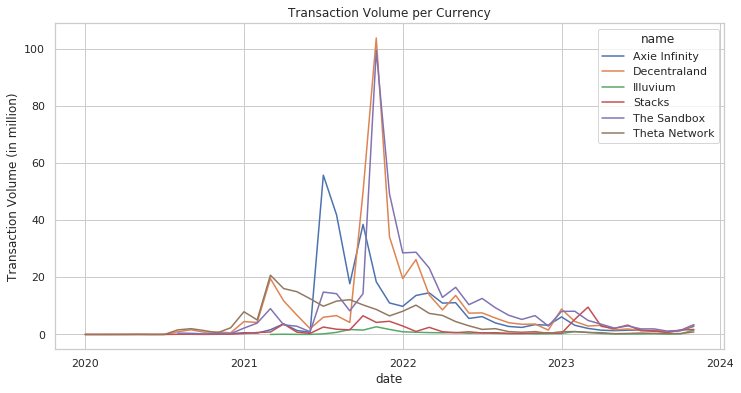

In [22]:
ax = data_top_5_currencies.groupby(['date', 'name'])['volume_million'].mean().unstack().plot();
ax.set_ylabel("Transaction Volume (in million)");
plt.title("Transaction Volume per Currency");
plt.savefig('trans_volume_per_curr.png');

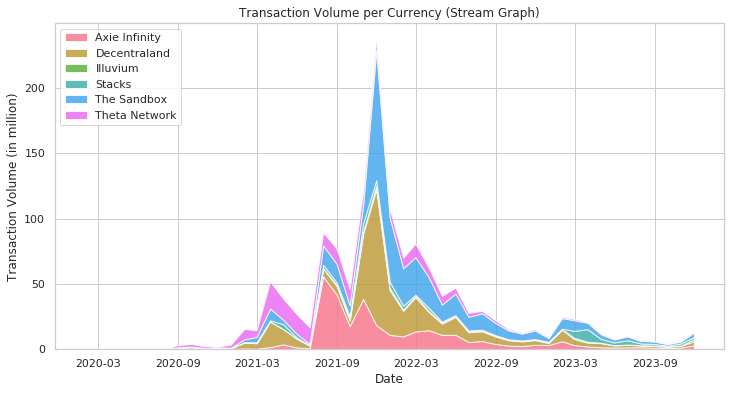

In [23]:
# Extract relevant columns for stream graph
stream_data_volume = data_top_5_currencies[['date', 'name', 'volume_million']]

# Pivot the dataframe to have 'date' as index, 'name' as columns, and 'volume_million' as values
stream_data_volume_pivot = stream_data_volume.pivot_table(index='date', columns='name', values='volume_million', fill_value=0)

# Create a list of colors for each currency
colors_volume = sns.color_palette("husl", n_colors=len(stream_data_volume_pivot.columns))

# Plot the stream graph
plt.figure(figsize=(12, 6))
plt.stackplot(stream_data_volume_pivot.index, stream_data_volume_pivot.values.T, labels=stream_data_volume_pivot.columns, colors=colors_volume, alpha=0.8)
plt.title('Transaction Volume per Currency (Stream Graph)')
plt.xlabel('Date')
plt.ylabel('Transaction Volume (in million)')
plt.legend(loc='upper left')
plt.savefig('new/trans_volume_per_curr_stream.png')

## Trend Charts in 2017

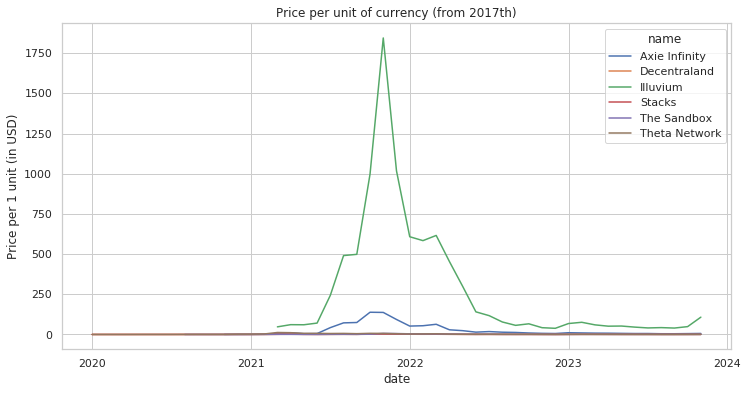

In [24]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit of currency (from 2017th)");

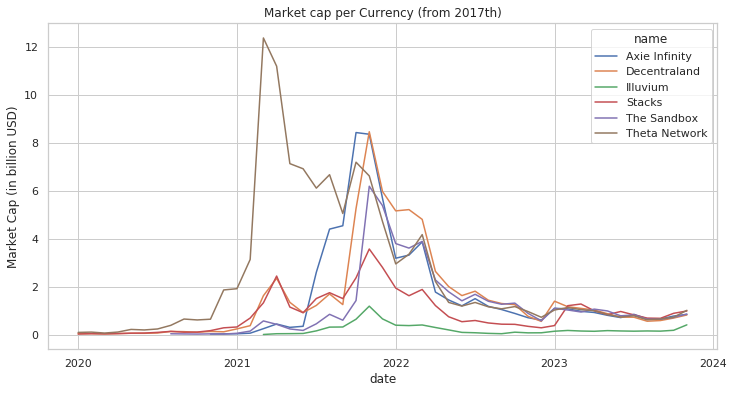

In [25]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2017].groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per Currency (from 2017th)");

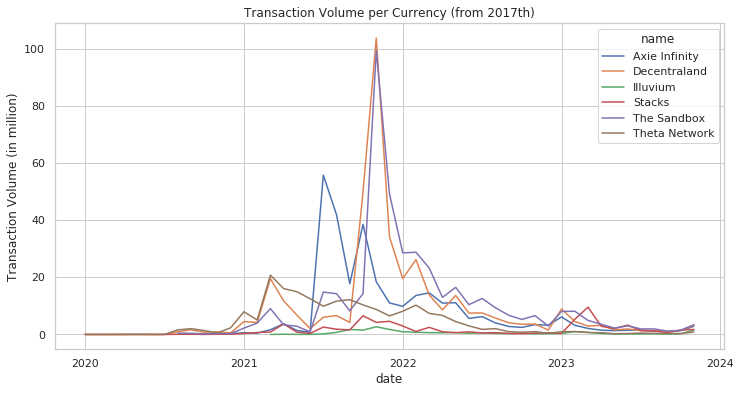

In [26]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2017].groupby(['date', 'name'])['volume_million'].mean().unstack().plot();
ax.set_ylabel("Transaction Volume (in million)");
plt.title("Transaction Volume per Currency (from 2017th)");

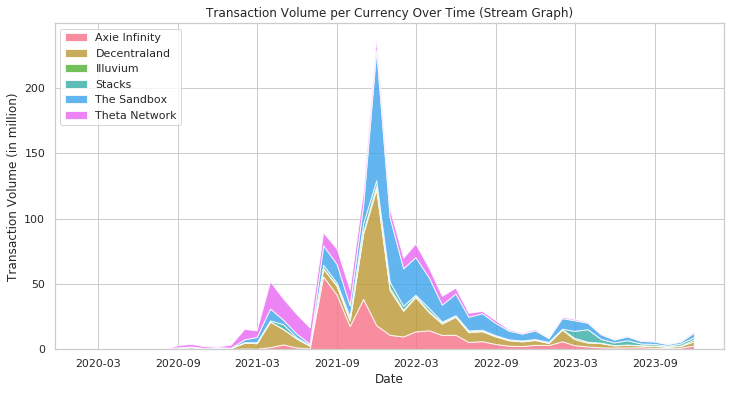

In [27]:
# Extract relevant columns for stream graph
stream_data_volume = data_top_5_currencies[['date', 'name', 'volume_million']]

# Pivot the dataframe to have 'date' as index, 'name' as columns, and 'volume_million' as values
stream_data_volume_pivot = stream_data_volume.pivot_table(index='date', columns='name', values='volume_million', fill_value=0)

# Create a list of colors for each currency
colors_volume = sns.color_palette("husl", n_colors=len(stream_data_volume_pivot.columns))

# Plot the stream graph
plt.figure(figsize=(12, 6))
plt.stackplot(stream_data_volume_pivot.index, stream_data_volume_pivot.values.T, labels=stream_data_volume_pivot.columns, colors=colors_volume, alpha=0.8)
plt.title('Transaction Volume per Currency Over Time (Stream Graph)')
plt.xlabel('Date')
plt.ylabel('Transaction Volume (in million)')
plt.legend(loc='upper left')
plt.show()

## Trend Charts in 2018

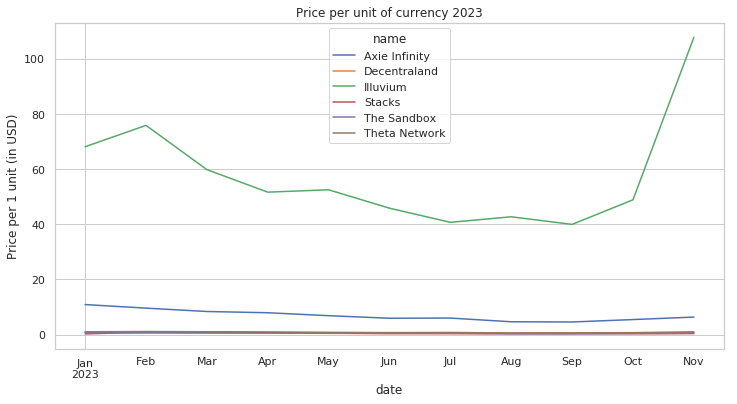

In [28]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2023].groupby(['date', 'name'])['close'].mean().unstack().plot();
ax.set_ylabel("Price per 1 unit (in USD)");
plt.title("Price per unit of currency 2023");
plt.savefig('price_per_unit_curr_2023.png');

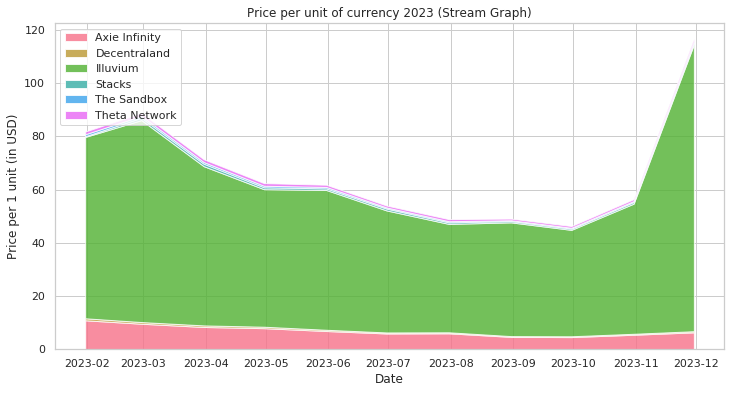

In [29]:
filtered_data = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2023]

# Group by date and name, calculate the mean, and unstack the result
stream_data = filtered_data.groupby(['date', 'name'])['close'].mean().unstack()

# Set up the colors
colors = sns.color_palette("husl", n_colors=len(stream_data.columns))

# Plot the stream graph
plt.figure(figsize=(12, 6))
plt.stackplot(stream_data.index, stream_data.values.T, labels=stream_data.columns, colors=colors, alpha=0.8)
plt.title('Price per unit of currency 2023 (Stream Graph)')
plt.xlabel('Date')
plt.ylabel('Price per 1 unit (in USD)')
plt.legend(loc='upper left')
plt.savefig('new/price_per_unit_curr_2023_stream.png');

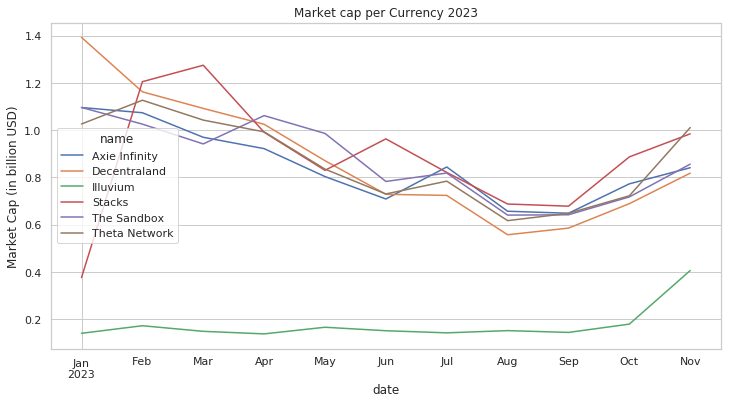

In [30]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2023].groupby(['date', 'name'])['market_billion'].mean().unstack().plot();
ax.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per Currency 2023");
plt.savefig('market_cap_per_curr_2023.png');

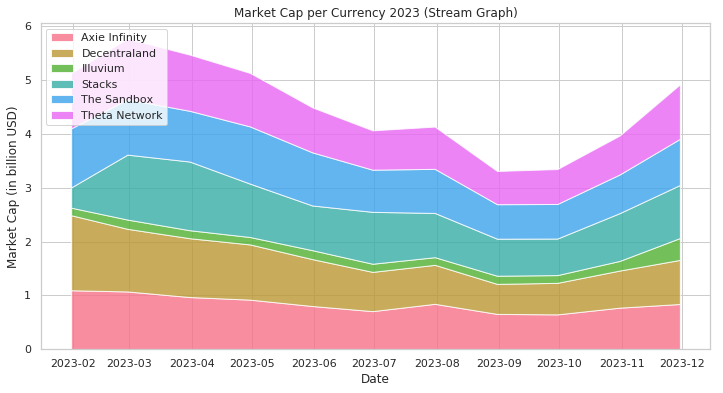

In [31]:
filtered_data = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2023]

# Group by date and name, calculate the mean, and unstack the result
stream_data = filtered_data.groupby(['date', 'name'])['market_billion'].mean().unstack()

# Set up the colors
colors = sns.color_palette("husl", n_colors=len(stream_data.columns))

# Plot the stream graph
plt.figure(figsize=(12, 6))
plt.stackplot(stream_data.index, stream_data.values.T, labels=stream_data.columns, colors=colors, alpha=0.8)
plt.title('Market Cap per Currency 2023 (Stream Graph)')
plt.xlabel('Date')
plt.ylabel('Market Cap (in billion USD)')
plt.legend(loc='upper left')
plt.savefig('new/market_cap_per_curr_2023_stream.png');

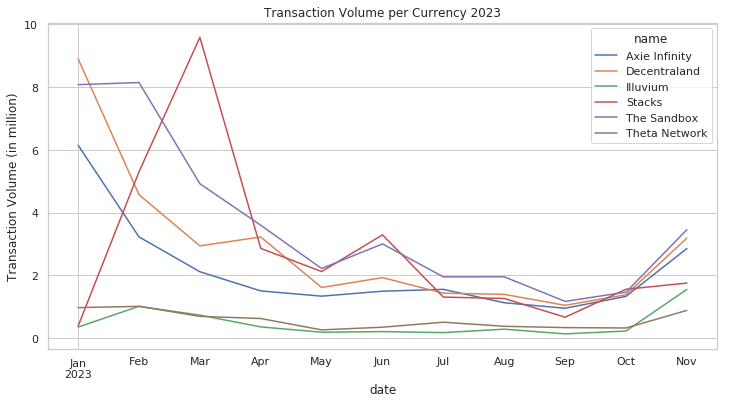

In [32]:
ax = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2023].groupby(['date', 'name'])['volume_million'].mean().unstack().plot();
ax.set_ylabel("Transaction Volume (in million)");
plt.title("Transaction Volume per Currency 2023");
plt.savefig('transact_volume_per_curr_2023.png');

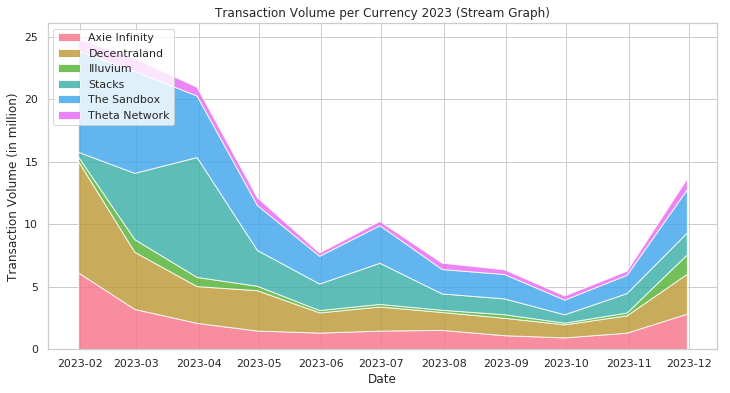

In [33]:
filtered_data = data_top_5_currencies[data_top_5_currencies.date.dt.year >= 2023]

# Group by date and name, calculate the mean, and unstack the result
stream_data = filtered_data.groupby(['date', 'name'])['volume_million'].mean().unstack()

# Set up the colors
colors = sns.color_palette("husl", n_colors=len(stream_data.columns))

# Plot the stream graph
plt.figure(figsize=(12, 6))
plt.stackplot(stream_data.index, stream_data.values.T, labels=stream_data.columns, colors=colors, alpha=0.8)
plt.title('Transaction Volume per Currency 2023 (Stream Graph)')
plt.xlabel('Date')
plt.ylabel('Transaction Volume (in million)')
plt.legend(loc='upper left')
plt.savefig('new/transact_volume_per_curr_2023_stream.png');

## Correlation

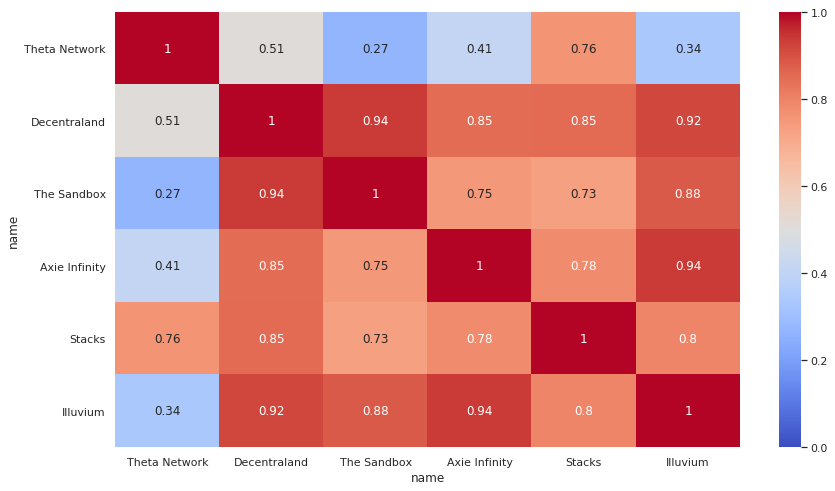

In [34]:
plt.figure(figsize=(14,8))
sns.heatmap(wide_format[top_5_currency_names].corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True);
plt.savefig('correlation.png');

In [35]:
def plot_roi(amount, df, fig_name):
    for column in df.columns:
        # Find the first non-missing value for each cryptocurrency
        initial_value = df[column].dropna().iloc[0]
        
        # Calculate the returns based on the initial value
        returns = (df[column] / initial_value) * amount
        
        # Plot the returns
        plt.plot(df.index, returns, label=column)

    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.title("Returns for Each Cryptocurrency in 2023")
    plt.savefig(fig_name);    

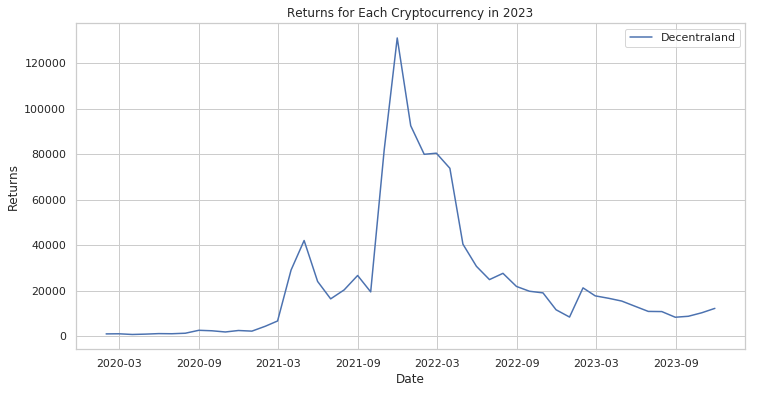

In [36]:
plot_roi(1000, wide_format[['Decentraland']], 'new/roi_decentraland.png')

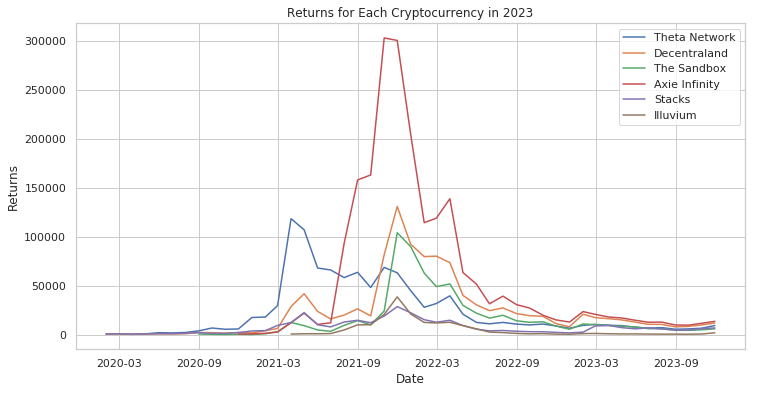

In [37]:
wide_format_2017th = wide_format[(wide_format.index.year >= 2017)]
name = 'new/roi_curr.png'
plot_roi(1000, wide_format_2017th[top_5_currency_names], name)

In [38]:
wide_format_late_2017th = wide_format[(wide_format.index.year >= 2023) & (wide_format.index.month >= 10)]
# name = 'roi_curr_2023.png'
# plot_roi(1000, wide_format_late_2017th[top_5_currency_names], name)

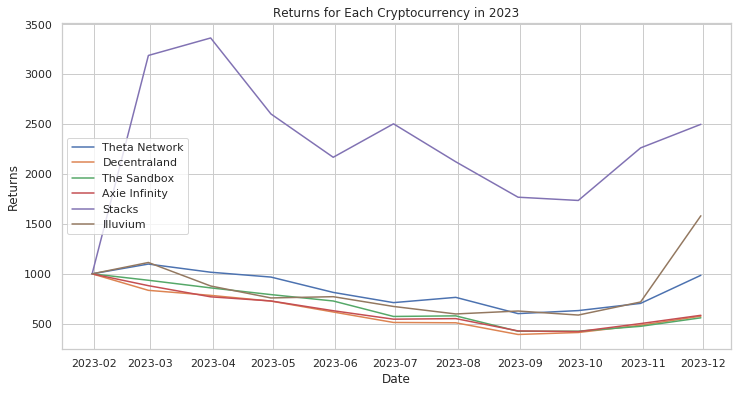

In [39]:
wide_format_2018th = wide_format[(wide_format.index.year >= 2023)]
name = 'new/roi_curr_2023.png'
plot_roi(1000, wide_format_2018th[top_5_currency_names], name)

In [40]:
len(data.slug.unique())

6

In [41]:
# Some common filters that we might be using
# is_bitcoin = data['symbol'] == 'BTC'
# is_ethereum = data['symbol'] == 'ETH'
# is_ripple  = data['symbol'] == 'XRP'

is_axs = data['symbol'] == 'AXS'
is_mana = data['symbol'] == 'MANA'
is_sand = data['symbol'] == 'SAND'

# Pull out a part of dataset that only has the most interesting currencies
# data_top_currencies = data[is_bitcoin | is_ethereum | is_ripple]
data_top_currencies = data[is_axs | is_mana | is_sand]

Let's chart out Top cryptocurrencies according to latest reported Market Cap

In [42]:
top10Currencies = data.groupby('name')['market_billion'].last().sort_values(ascending=False).head(10)

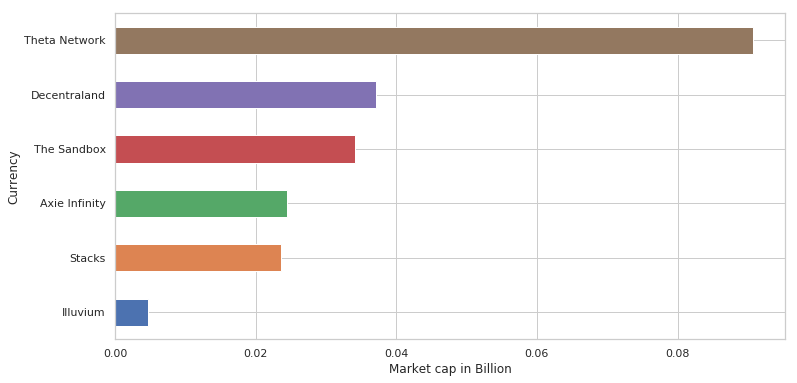

In [43]:
ax = top10Currencies.sort_values().plot(kind='barh')
ax.set_xlabel("Market cap in Billion");
ax.set_ylabel("Currency");

As we can see, and as it was expected, Bitcoin has the highest market cap. Let's see the trend for couple of top currencies.

Text(0,0.5,'Price per 1 unit (in USD)')

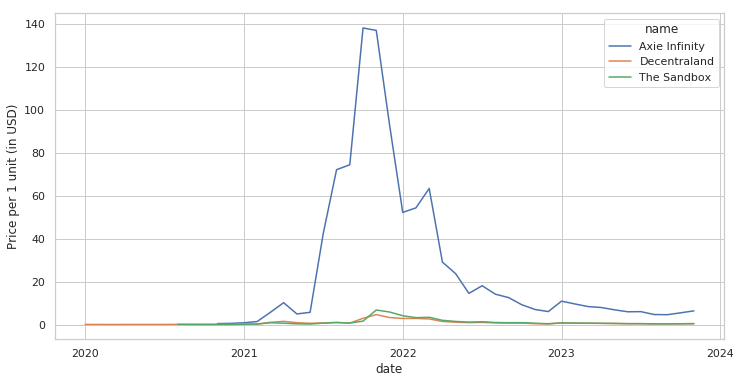

In [44]:
ax = data_top_currencies.groupby(['date', 'name'])['close'].mean().unstack().plot()
ax.set_ylabel("Price per 1 unit (in USD)")

Text(20.2,0.5,'Price per 1 unit (in USD)')

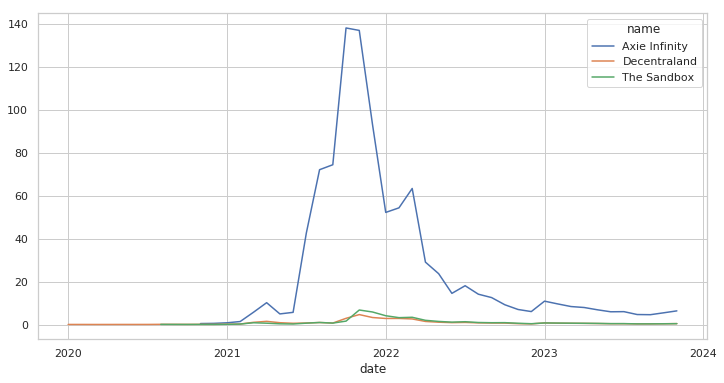

In [45]:
data_top_currencies[data_top_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['close'].mean().unstack().plot()
ax.set_ylabel("Price per 1 unit (in USD)")

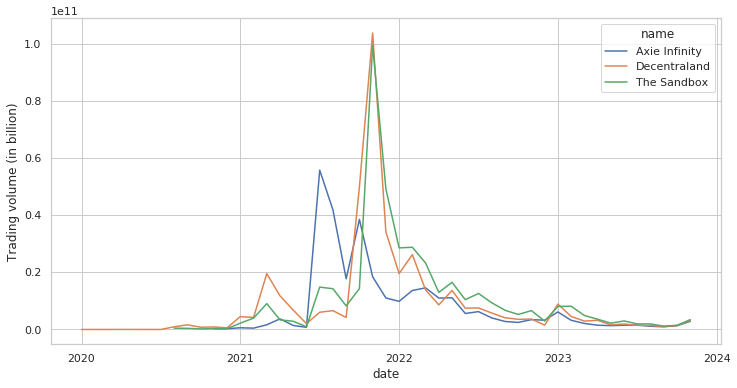

In [46]:
ax = data_top_currencies[data_top_currencies.date.dt.year >= 2018].groupby(['date', 'name'])['volume_billion'].mean().unstack().plot()
ax.set_ylabel("Trading volume (in billion)");

In [47]:
def plot_with_textvalue(df):
    ax = df.plot(kind='bar')
    
    ax.set_ylabel("Yearly closing prices (in USD)")

    for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

In [48]:
top10Currencies

name
Theta Network   0.09
Decentraland    0.04
The Sandbox     0.03
Axie Infinity   0.02
Stacks          0.02
Illuvium        0.00
Name: market_billion, dtype: float64

In [49]:
# closing_prices_bitcoin_and_ethereum = data[is_bitcoin | is_ethereum].groupby(['date','name'])['close'].last().unstack().reset_index()
# closing_prices_other_currencies = data[data['name'].isin(top10Currencies.index) & ~is_bitcoin & ~is_ethereum].groupby(['date','name'])['close'].last().unstack().reset_index()

closing_prices_bitcoin_and_ethereum = data[is_mana | is_sand].groupby(['date','name'])['close'].last().unstack().reset_index()
closing_prices_other_currencies = data[data['name'].isin(top10Currencies.index) & ~is_sand & ~is_mana].groupby(['date','name'])['close'].last().unstack().reset_index()

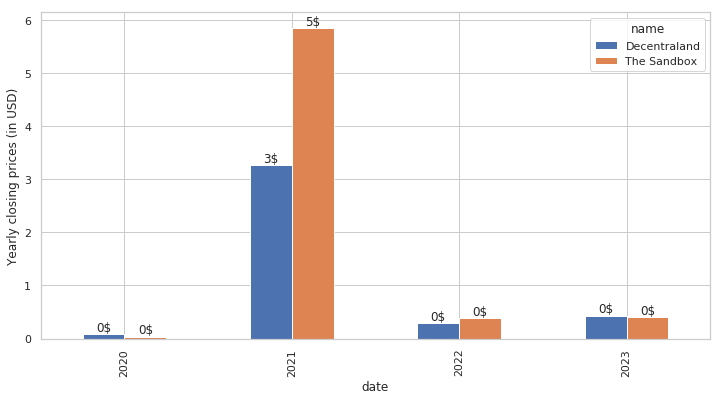

In [50]:
yearly_closing_prices_bitcoin_and_ethereum = closing_prices_bitcoin_and_ethereum.groupby(closing_prices_bitcoin_and_ethereum.date.dt.year).last()
yearly_closing_prices_bitcoin_and_ethereum.drop(columns='date', inplace=True)
plot_with_textvalue(yearly_closing_prices_bitcoin_and_ethereum)

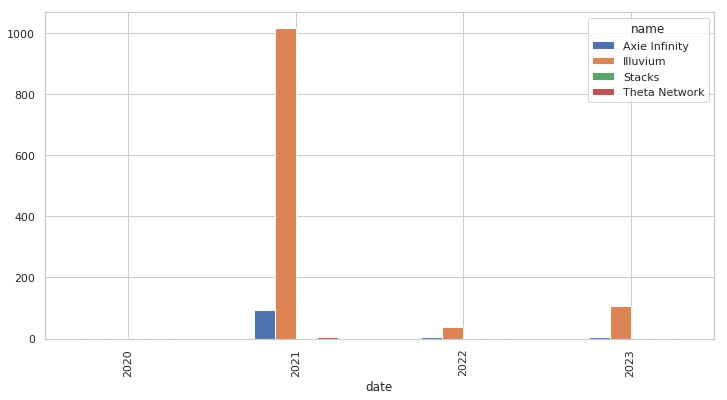

In [51]:
yearly_closing_prices_other_currencies = closing_prices_other_currencies.groupby(closing_prices_other_currencies.date.dt.year).last()
yearly_closing_prices_other_currencies.drop(columns='date', inplace=True)
yearly_closing_prices_other_currencies.plot(kind='bar')

In [52]:
closing_prices_other_currencies.head()

name,date,Axie Infinity,Illuvium,Stacks,Theta Network
0,2020-01-31,nan,nan,0.10,0.10
1,2020-02-29,nan,nan,0.12,0.12
2,2020-03-31,nan,nan,0.09,0.07
3,2020-04-30,nan,nan,0.10,0.12
4,2020-05-31,nan,nan,0.13,0.25


Let's plot the closing prices.

In [53]:
closing_prices_bitcoin_and_ethereum.head()

name,date,Decentraland,The Sandbox
0,2020-01-31,0.04,nan
1,2020-02-29,0.04,nan
2,2020-03-31,0.03,nan
3,2020-04-30,0.03,nan
4,2020-05-31,0.04,nan


In [54]:
closing_prices_other_currencies.head()

name,date,Axie Infinity,Illuvium,Stacks,Theta Network
0,2020-01-31,nan,nan,0.10,0.10
1,2020-02-29,nan,nan,0.12,0.12
2,2020-03-31,nan,nan,0.09,0.07
3,2020-04-30,nan,nan,0.10,0.12
4,2020-05-31,nan,nan,0.13,0.25


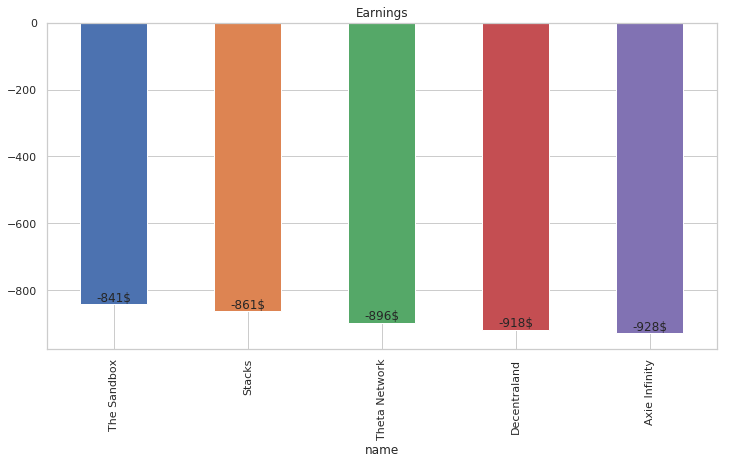

In [62]:
def calc_earnings(currency_name, df):
    #print("Displaying stats for "+currency_name)

    closing_prices = df[(df['name'] == currency_name) & (~df['close'].isnull())][['date', 'close']]

    # Num. currency purchased for 1000$
    #print("Closing price at the beginning: " + str(closing_prices.iloc[0]['close']))

    num_units_purchased = 1000 / closing_prices.iloc[0]['close']
    num_units_purchased

    #print("Num. units purchased: " + str(num_units_purchased))

    # Current value
    last_price = closing_prices.iloc[-1]['close']
    #print("Last price: " + str(last_price))

    amount_earned = (num_units_purchased * last_price) - 1000

    #print("Amount you would have earned: " + str(amount_earned) + "$")
    
    return amount_earned
    
# Borrow the index :-)
top_10_currencies_earnings = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings[currency] = calc_earnings(currency, data)
    
ax = top_10_currencies_earnings.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')
plt.title('Earnings')
plt.savefig('new/earnings.png')

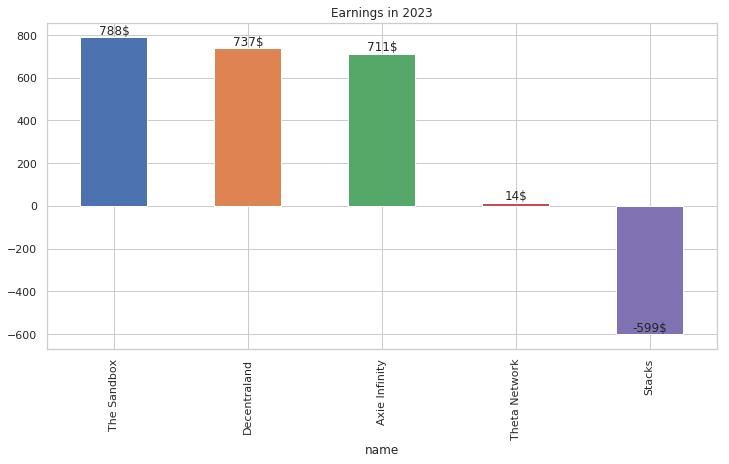

In [63]:
# Borrow the index :-)
top_10_currencies_earnings_2018 = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings_2018[currency] = calc_earnings(currency, data[data.date.dt.year >= 2023])
    
top_10_currencies_earnings_2018

ax = top_10_currencies_earnings_2018.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')
plt.title('Earnings in 2023')
plt.savefig('new/earnings_2023.png')

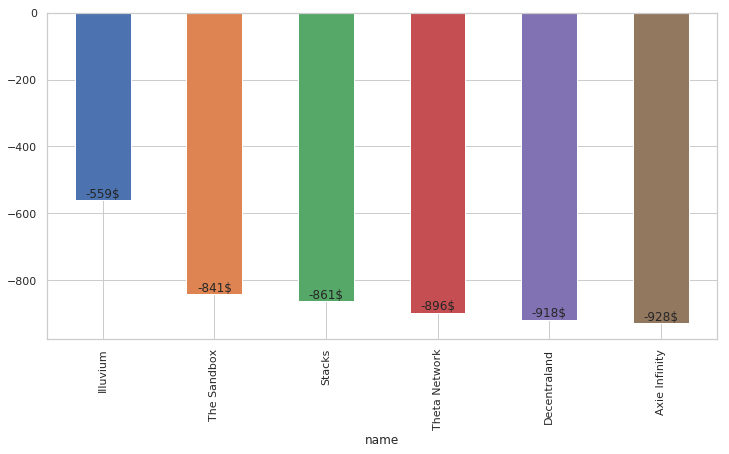

In [57]:
# Borrow the index :-)
top_10_currencies_earnings_2018 = top10Currencies

for currency in top10Currencies.index:
    top_10_currencies_earnings_2018[currency] = calc_earnings(currency, data[data.date.dt.year >= 2018])
    
top_10_currencies_earnings_2018

ax = top_10_currencies_earnings_2018.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

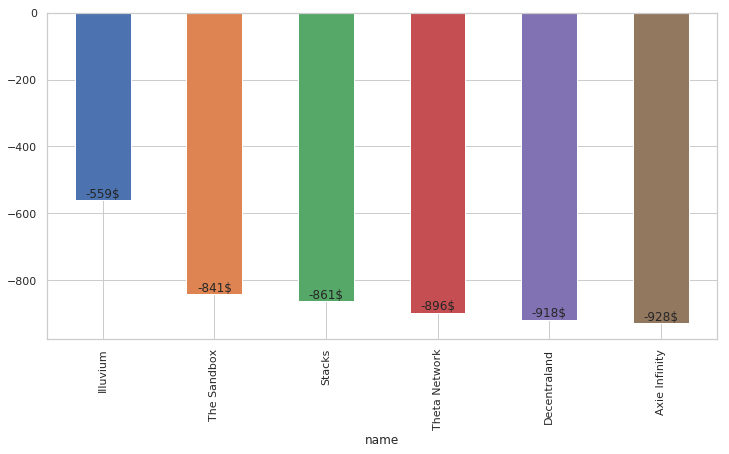

In [58]:
top_10_currencies_earnings_without_nem = top_10_currencies_earnings[top_10_currencies_earnings.index != 'NEM']

ax = top_10_currencies_earnings_without_nem.sort_values(ascending=False).plot(kind='bar')
for rect in ax.patches:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d$' % int(height), ha='center', va='bottom')

Text(0.5,1,'Correlation Heatmap between Bitcoin and other top 5 Crypto')

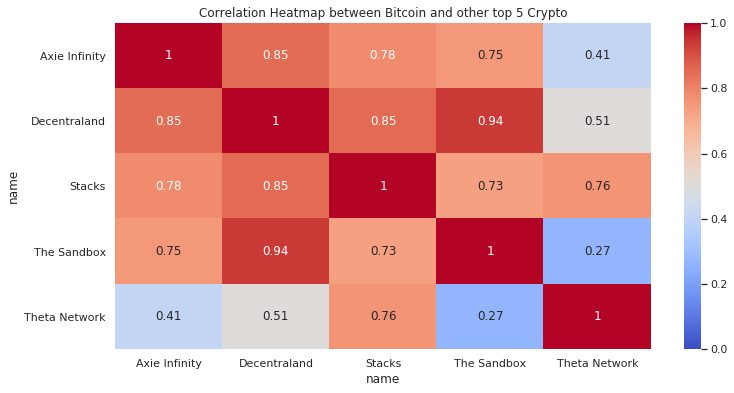

In [59]:
top10Currencies = data.groupby('name')['market_billion'].last().sort_values(ascending=False).head(5)
closing_prices_top10 = data[data['name'].isin(top10Currencies.index)].groupby(['date', 'name'])['close'].mean().unstack()
closing_prices_top10.corr()

plt.figure(figsize=(12,6))
sns.heatmap(closing_prices_top10.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other top 5 Crypto')

Text(0.5,1,'Correlation Heatmap between Bitcoin and other top 4 Crypto')

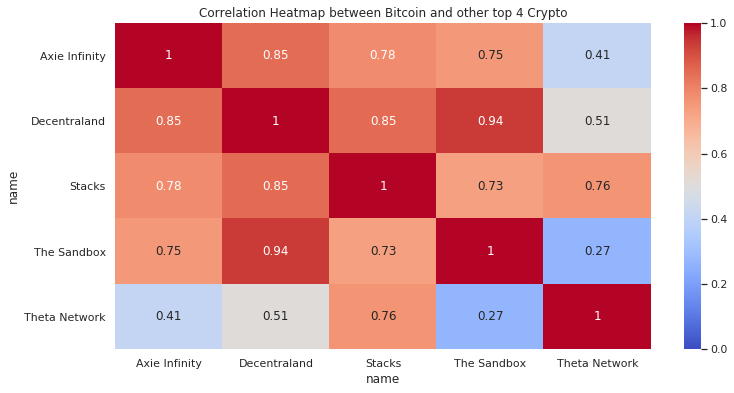

In [60]:
plt.figure(figsize=(12,6))
sns.heatmap(closing_prices_top10.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap between Bitcoin and other top 4 Crypto')

**Copyright** by [Quanonblocks](https://www.kaggle.com/quanonblocks)


Released under the [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0) open source license.